# Multivariate regression for EV energy consumption prediction

Data description:

In 'trips_bulk.csv', EV data from electric buses operating in the City of Turku are recorded; in total, the dataset contains 25 256 unique trips that were made in year 2017 on one of the four route segments:

 - Turku harbor --> Marketplace
 - Marketplace --> Turku Airport
 - Turku Airport --> Marketplace
 - Marketplace --> Turku harbor
 
The individual trips are encoded in the data by parameter 'duration', wherein a zero value designates the beginning point of a trip.

The variables in the dataset are:

 - timestamp: A timestamp string in format yyyy-MM-DD HH:mm:ss
 - gpslong: GPS Longitude
 - gpslat: GPS Latitude
 - altitude: Approximate altitude from sea level in meters, that has been inferred from (gpslong, gpslat) by interpolation
 - speed: the instantaneous vehicle drivin speed in km/h
 - soc: the state of charge of the EV battery in %
 - temp: ambient temperature in deg C
 - duration: a running duration of the current trip in s
 
Predicted variable is the (normalized) SOC, that is, given a sequence of the other variables, the task of our model is to infer the corresponding SOC sequence.

In [1]:
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./data/dummy_data.csv')

Subsample the data for faster iterations 

In [ ]:
#data = data.iloc[0:100, :]

In [3]:
data

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration
0,2017-01-01 12:07:35,22.273872,60.510728,56.888984,25.570312,57.516667,-0.661392,0
1,2017-01-01 12:07:40,22.253635,60.510382,56.192922,27.574219,57.420000,-0.677215,5
2,2017-01-01 12:07:45,22.273475,60.509920,55.654167,30.535156,57.320000,-0.693038,10
3,2017-01-01 12:07:50,22.273783,60.509452,55.177280,31.160156,57.233333,-0.708861,15
4,2017-01-01 12:07:55,22.274570,60.509088,53.519203,34.199219,57.140000,-0.724684,20
5,2017-01-01 12:08:00,22.274570,60.509088,53.519203,32.167969,57.066667,-0.740506,25
6,2017-01-01 12:08:05,22.275470,60.508837,53.781415,33.433594,57.011111,-0.756329,30
7,2017-01-01 12:08:10,22.276275,60.508637,53.133231,35.300781,57.050000,-0.772152,35
8,2017-01-01 12:08:15,22.277145,60.508402,50.440074,31.132812,57.120000,-0.787975,40
9,2017-01-01 12:08:20,22.277768,60.508077,50.126894,17.683594,57.188889,-0.803797,45


### Explore the data

In [4]:
len(data)

100

In [5]:
data.head()

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration
0,2017-01-01 12:07:35,22.273872,60.510728,56.888984,25.570312,57.516667,-0.661392,0
1,2017-01-01 12:07:40,22.253635,60.510382,56.192922,27.574219,57.420000,-0.677215,5
2,2017-01-01 12:07:45,22.273475,60.509920,55.654167,30.535156,57.320000,-0.693038,10
3,2017-01-01 12:07:50,22.273783,60.509452,55.177280,31.160156,57.233333,-0.708861,15
4,2017-01-01 12:07:55,22.274570,60.509088,53.519203,34.199219,57.140000,-0.724684,20


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gpslong,100.0,22.289200,0.008241,22.253635,22.285158,22.289137,22.295182,22.300948
gpslat,100.0,60.499477,0.009270,60.483467,60.491136,60.500920,60.508670,60.510728
altitude,100.0,40.572304,7.508203,30.016401,34.361449,36.863242,47.919198,56.888984
speed,100.0,33.353516,13.849304,0.000000,27.829102,37.169922,43.816406,49.632812
soc,100.0,54.391692,1.802786,51.200000,52.647500,54.528333,55.897500,57.516667
temp,100.0,-0.478273,0.312610,-1.000000,-0.776108,-0.420502,-0.203302,0.000000
duration,100.0,36.700000,34.831630,0.000000,10.000000,25.000000,50.000000,140.000000


A very nice way to outline the data is to plot a heatmap representation of (gpslat, gpslong) data utilizing matplotlibs 2d-histogram capability. With a binning dense enough, we clearly outline the representation of the turku ebus route 1

<IPython.core.display.Javascript object>


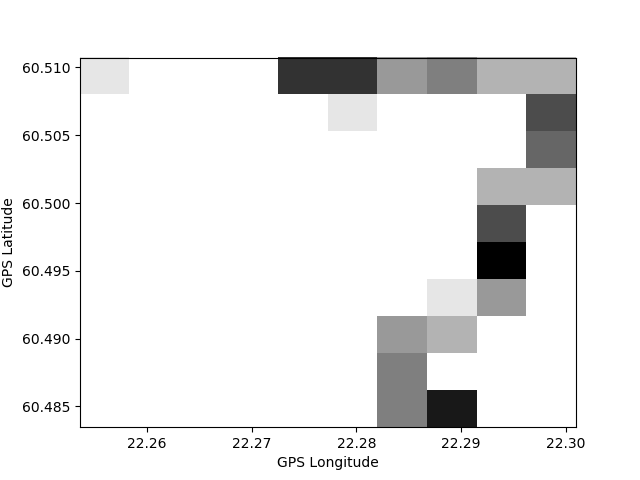

In [7]:
plt.figure()
h, xedges, yedges, _ = plt.hist2d(data['gpslong'], data['gpslat'], bins=10, cmap='binary')
plt.xlabel('GPS Longitude')
plt.ylabel('GPS Latitude')
plt.show()

In [8]:
h.shape

(10, 10)

In [9]:
xedges.shape

(11,)

In [10]:
xedges

array([22.253635  , 22.25836633, 22.26309767, 22.267829  , 22.27256033,
       22.27729167, 22.282023  , 22.28675433, 22.29148567, 22.296217  ,
       22.30094833])

In [11]:
yedges

array([60.48346667, 60.48619283, 60.488919  , 60.49164517, 60.49437133,
       60.4970975 , 60.49982367, 60.50254983, 60.505276  , 60.50800217,
       60.51072833])

In [52]:
h

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  8.],
       [ 5.,  5.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  4.],
       [ 9.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  5.],
       [ 0.,  0.,  0.,  4., 10.,  7.,  3.,  0.,  0.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  6.,  7.,  3.]])

In [57]:
h.nonzero()[0].shape

(21,)

We wish to remove the instances that are not relevant to our problem, ebus operating on route. Hence we need a way to identify from the data those rows where (gpslat, gpslong) is outside the "tolerance area", i.e. the route depicted in black/greyish in above figure. First of all, we need some way of representing a single "slice" of the tolerance area, e.g. as a bounding box:

bbox = (lat_min, lat_max, long_min, long_max)

Consequently, the whole route's tolerance area could be represented as an array of bbox instances

Let's define a couple of helper classes

In [12]:
class BoundingBox(object):
    
    def __init__(self, lat_min, lat_max, long_min, long_max):
        self.lat_min = lat_min
        self.lat_max = lat_max
        self.long_min = long_min
        self.long_max = long_max
        
    def contains(self, lat, long):
        return self.lat_min <= lat <= self.lat_max and self.long_min <= long <= self.long_max

In [13]:
import warnings

In [14]:
class BoundingBoxSet(object):
    
    def __init__(self, boxes=[]):
        self.boxes = boxes
        
    def init_from_histogram(self, h, xedges, yedges, tolerance):
        """
        consumes h, xedged, yedges variables provided by matplotlib.pyplot.hist2d
        and constructs the bounding boxes according to the specified tolerance 
        """
        
        if len(self.boxes) > 0:
            warnings.warn("BoundingBoxSet has been previously initialized, setting self.boxes = []")
            self.boxes = []
        
        rows = h.shape[0]
        cols = h.shape[1]
        
        for row in range(rows):
            for col in range(cols):
                if h[row][col] > tolerance:
                    long_min = xedges[row]
                    long_max = xedges[row+1]
                    lat_min = yedges[col]
                    lat_max = yedges[col+1]

                    self.boxes.append(BoundingBox(lat_min, lat_max, long_min, long_max))
                    
        

In [15]:
bbox_set = None
bbox_set = BoundingBoxSet()

In [16]:
bbox_set.init_from_histogram(h, xedges, yedges, 1)

In [17]:
len(bbox_set.boxes)

18

Subsequently, we need to iterate through the dataset and check each (gpslat, gpslong) against every instance in BoundingBoxSet. If (gpslat, gpslong) is not inside any BoundingBox, we flag that row (and hence, the trip that the row belongs to) to be deleted

In [18]:
def check_location_against_bbox_set(row):
    """
    Check if a provided location is contained in any of the boundingboxes
    Return true if it is, flase otherwise
    """
    
    for box in bbox_set.boxes:
        if box.contains(row['gpslat'], row['gpslong']):
            return True  
    return False

In [ ]:
data['is_in_tolerance_area'] = pd.Series()

In [ ]:
data.head()

In [ ]:
data['is_in_tolerance_area'] = data.apply(check_location_against_bbox_set, axis=1)

In [22]:
def check_tolerances_dataset(data):
    data.loc[:, 'is_in_tolerance_area'] = data.apply(check_location_against_bbox_set, axis=1)
    return data

In [50]:
data = check_tolerances_dataset(data)

In [51]:
data.head()

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration,is_in_tolerance_area,sequence,distance,rel_altitude,rel_soc
11,2017-01-01 12:08:30,22.278402,60.508038,49.873498,21.640625,57.02,-0.835443,0,True,2,0.000000,0.000000,-0.00
12,2017-01-01 12:08:35,22.279068,60.508390,49.581050,34.296875,56.82,-0.851266,5,True,2,0.053487,-0.292448,0.20
13,2017-01-01 12:08:40,22.279718,60.508770,49.267361,38.804688,56.66,-0.867089,10,True,2,0.108692,-0.606137,0.36
14,2017-01-01 12:08:45,22.280368,60.509187,49.219072,39.445312,56.62,-0.882911,15,True,2,0.167016,-0.654427,0.40
15,2017-01-01 12:08:50,22.281038,60.509678,49.280735,38.101562,56.67,-0.898734,20,True,2,0.232565,-0.592763,0.35


In [25]:
len(data[data['is_in_tolerance_area'] == False])

3

So we have 41336 rows where the tolerance condition is not met

Next, we need some way of accessing the individual samples. We will build indexing based on the duration variable

In [26]:
def build_sample_indices(data, col):
    """
    Builds sequence indices based on duration data
    Iterate over the rows in data and increment index whenever duration == 0
    
    Args:
        data (pd.DataFrame) : The dataframe whose indices are to be built.
        col (string) : The column of the dataframe with respect to the indexing
    Returns:
         data (pd.Series) : Data with an added column for the sequence indices
    """
    
    idx = 0
    seq_indices = []
    for _, row in data.iterrows():
        if row[col] == 0:
            #increment index and begin new sequence
            idx += 1
            seq_indices.append(idx)
        else:
            seq_indices.append(idx)
    
    data['sequence'] = seq_indices
    
    return data

Ok, that's enough testing. Let's do the real deal but first we'll save the current state of the data

Iterate over the rows in the full dataset and build the sequence indices

In [29]:
data = build_sample_indices(data, 'duration')

In [30]:
data.head()

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration,is_in_tolerance_area,sequence
0,2017-01-01 12:07:35,22.273872,60.510728,56.888984,25.570312,57.516667,-0.661392,0,True,1
1,2017-01-01 12:07:40,22.253635,60.510382,56.192922,27.574219,57.420000,-0.677215,5,False,1
2,2017-01-01 12:07:45,22.273475,60.509920,55.654167,30.535156,57.320000,-0.693038,10,True,1
3,2017-01-01 12:07:50,22.273783,60.509452,55.177280,31.160156,57.233333,-0.708861,15,True,1
4,2017-01-01 12:07:55,22.274570,60.509088,53.519203,34.199219,57.140000,-0.724684,20,True,1


In [31]:
data['sequence'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [32]:
data['is_in_tolerance_area'].value_counts()[False]

3

Now that we have the sequences, we will deal with the samples not in our area of interest. It is not sufficient to simply drop the rows where is_in_tolerance_area == False, instead we have to drop the whole corresponding sequence

In [33]:
def drop_sequences(data, cond_col, condition, threshold):
    """
    Drop sequences including at threshold rows where the column
    cond_col evaluates to condition
    
    Args:
        data (pd.DataFrame) : data to be pruned
        cond_col (string) : the name of the column to be checked for a logical condition
        condition (bool) : The condition
        threshold (int) : occurence threshold for removing the sequence
    Returns:
        data_dropped (pd.DataFrame) : data where the affected rows have been dropped
    """
    seq_ids = list(data['sequence'].unique())
    to_be_dropped = []
    for seq_id in seq_ids:
        seq = data[data['sequence'] == seq_id]
        try:
            if seq[cond_col].value_counts()[condition] > threshold:
                to_be_dropped.append(seq.index.tolist())
        except:
            pass
        
    to_be_dropped = [idx for seq in to_be_dropped for idx in seq]
    return data.drop(to_be_dropped)
            
        

In [34]:
data = drop_sequences(data, 'is_in_tolerance_area', False, 0)

In [35]:
len(data)

60

In [36]:
data['sequence'].unique()

array([2, 3, 4, 5, 6, 7, 8], dtype=int64)

Finally we get to do some actual feature engineering. We want to represent the data not tied to an absolute geolocation, but instead we want relative columns for gpslat, long and altitude. For gpslat / long, we want to replace with a running distance feature from the sequence origin. For this, we will utilize something called Haversine formula for computing the distance between two (gpslat, gpslong) pairs.

In [37]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [38]:
haversine(22.273871666666697, 60.510728333333304 , 22.273871666666697 , 60.510728333333304)

0.0

In [39]:
def compute_distance_between_rows(row1, row2, gpslat_col, gpslong_col):
    """
    Compute the haversine distance given two rows sliced from a pd.DataFrame.
    Rows are expected to be identical in their columns
    
    Args:
        row1 (pd.Series of shape (1, n_features)) 
        row2 (pd.Series of shape (1, n_features))
        gpslat_col (string) : the identifier of the column of gps latitude in both rows
        gpslong_col (string) : the identifier of the column of gps longitude in both rows
    
    Returns:
        distance (float)
    """
    lon1 = row1[gpslong_col]
    lat1 = row1[gpslat_col]
    lon2 = row2[gpslong_col]
    lat2 = row2[gpslat_col]
        
    return haversine(lon1, lat1, lon2, lat2)
    

In [40]:
seq = data[data['sequence'] == 3]

In [41]:
compute_distance_between_rows(seq.iloc[0,:], seq.iloc[0,:], 'gpslat', 'gpslong')

0.0

In [42]:
def convert_sequence_to_relative(seq):
    """
    Converts gpslat, gpslong and altitude to running relative metrics
    
    Args:
        seq (pd.DataFrame) : the sequence to be converted
    
    Returns:
        distance (pd.Series) : running distance offset (meters) from the beginning of the series
        rel_altitude (pd.Series) : running altitude offset (meters) from the beginning of the series
        rel_soc (pd.Series) : the additive inverse of SOC offset from beginning of the series
    """
    first_row = seq.iloc[0,:]
    args = (first_row, 'gpslat', 'gpslong')
    
    distance = seq.apply(compute_distance_between_rows, args=args, axis=1)
    rel_altitude = seq.apply(lambda row : row['altitude'] - first_row['altitude'], axis=1)
    rel_soc = seq.apply(lambda row : -1*(row['soc'] - first_row['soc']), axis=1)
    
    return distance, rel_altitude, rel_soc
    

Testing

In [43]:
seq = data[data['sequence'] == 4]

In [44]:
seq

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration,is_in_tolerance_area,sequence
34,2017-01-01 12:10:25,22.299345,60.507397,43.900000,43.527344,54.760000,-0.585366,0,True,4
35,2017-01-01 12:10:30,22.300027,60.506903,47.092198,31.132812,54.920000,-0.544715,5,True,4
36,2017-01-01 12:10:35,22.300538,60.506550,48.433889,18.003906,55.060000,-0.504065,10,True,4
37,2017-01-01 12:10:40,22.300685,60.506307,47.882148,15.882812,55.057143,-0.463415,15,True,4
38,2017-01-01 12:10:45,22.300757,60.506063,46.744988,19.363281,54.980000,-0.422764,20,True,4
39,2017-01-01 12:10:50,22.300948,60.505790,45.715476,29.972656,54.883333,-0.382114,25,True,4
40,2017-01-01 12:10:55,22.300905,60.505253,43.136185,36.863281,54.800000,-0.341463,30,True,4


In [45]:
convert_sequence_to_relative(seq)

(34    0.000000
 35    0.066345
 36    0.114590
 37    0.141673
 38    0.167192
 39    0.199050
 40    0.253167
 dtype: float64, 34    0.000000
 35    3.192198
 36    4.533889
 37    3.982148
 38    2.844988
 39    1.815476
 40   -0.763815
 dtype: float64, 34   -0.000000
 35   -0.160000
 36   -0.300000
 37   -0.297143
 38   -0.220000
 39   -0.123333
 40   -0.040000
 dtype: float64)

In [46]:
seq

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration,is_in_tolerance_area,sequence
34,2017-01-01 12:10:25,22.299345,60.507397,43.900000,43.527344,54.760000,-0.585366,0,True,4
35,2017-01-01 12:10:30,22.300027,60.506903,47.092198,31.132812,54.920000,-0.544715,5,True,4
36,2017-01-01 12:10:35,22.300538,60.506550,48.433889,18.003906,55.060000,-0.504065,10,True,4
37,2017-01-01 12:10:40,22.300685,60.506307,47.882148,15.882812,55.057143,-0.463415,15,True,4
38,2017-01-01 12:10:45,22.300757,60.506063,46.744988,19.363281,54.980000,-0.422764,20,True,4
39,2017-01-01 12:10:50,22.300948,60.505790,45.715476,29.972656,54.883333,-0.382114,25,True,4
40,2017-01-01 12:10:55,22.300905,60.505253,43.136185,36.863281,54.800000,-0.341463,30,True,4


So now we have driven distance and altitude in a relative format, using the starting point of a sequence as the reference point. This should, theoretically, generalize better to unseen samples. Let's try this for the whole dummy dataset

In [47]:
def convert_dataset_to_relative(data):
    """
    Iterate over sequences in the whole dataset and make the necessary conversions
    """
    seq_ids = list(data['sequence'].unique())
    
    for seq_id in seq_ids:
        seq = data[data['sequence'] == seq_id]
        distance, rel_altitude, rel_soc = convert_sequence_to_relative(seq)
        data.loc[seq.index, 'distance'] = distance
        data.loc[seq.index, 'rel_altitude'] = rel_altitude
        data.loc[seq.index, 'rel_soc'] = rel_soc
    
    return data
    

In [48]:
data = convert_dataset_to_relative(data)

In [49]:
data

,timestamp,gpslong,gpslat,altitude,speed,soc,temp,duration,is_in_tolerance_area,sequence,distance,rel_altitude,rel_soc
11,2017-01-01 12:08:30,22.278402,60.508038,49.873498,21.640625,57.020000,-0.835443,0,True,2,0.000000,0.000000,-0.000000
12,2017-01-01 12:08:35,22.279068,60.508390,49.581050,34.296875,56.820000,-0.851266,5,True,2,0.053487,-0.292448,0.200000
13,2017-01-01 12:08:40,22.279718,60.508770,49.267361,38.804688,56.660000,-0.867089,10,True,2,0.108692,-0.606137,0.360000
14,2017-01-01 12:08:45,22.280368,60.509187,49.219072,39.445312,56.620000,-0.882911,15,True,2,0.167016,-0.654427,0.400000
15,2017-01-01 12:08:50,22.281038,60.509678,49.280735,38.101562,56.670000,-0.898734,20,True,2,0.232565,-0.592763,0.350000
16,2017-01-01 12:08:55,22.281038,60.509678,49.280735,26.511719,56.733333,-0.914557,25,True,2,0.232565,-0.592763,0.286667
17,2017-01-01 12:09:00,22.281497,60.509960,48.351357,20.085938,56.766667,-0.930380,30,True,2,0.272694,-1.522142,0.253333
18,2017-01-01 12:09:05,22.282140,60.509995,47.757627,30.421875,56.600000,-0.946203,35,True,2,0.298685,-2.115871,0.420000
19,2017-01-01 12:09:10,22.283115,60.509885,48.030347,42.367188,56.300000,-0.962025,40,True,2,0.329746,-1.843151,0.720000
20,2017-01-01 12:09:15,22.284523,60.509835,48.145780,44.449219,56.200000,-0.977848,45,True,2,0.390133,-1.727719,0.820000


Success!

In [ ]:
data = pd.read_csv('./data/trips_bulk.csv')

In [ ]:
data = data[1:5000]

In [ ]:
len(data)